In [41]:
# Import necessary packages
import numpy as np
import pylab as py
import matplotlib.pyplot as plt

# SPISEA imports
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# Imports for diagram colormaps 
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# CSV parsing for reading S284 data
import csv

In [42]:
# Estimation variables
star_index = 0      # Set which star in the CSV to analyze
num_top_predictions = 10     # Control how many top predictions to plot

# Isochrone instantiation

In [43]:
# define isochrone parameters
AKs = 0
dist = 4500
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F162M', 'jwst,F182M', 'jwst,F200W', 'jwst,F356W', 'jwst,F405N']
filters = ['m_jwst_F162M', 'm_jwst_F182M', 'm_jwst_F200W', 'm_jwst_F356W', 'm_jwst_F405N']
iso_dir = 'isochrones/'
metallicity = 0

In [44]:
# define log age array for isochrone grid
level_ages = np.linspace(1, 10, 19) * 1e6
log_age_arr = np.log10(level_ages)

In [45]:
instances = np.array([
    synthetic.IsochronePhot(log_age, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                            iso_dir=iso_dir)
    for log_age in log_age_arr
])

# Function for calculating chi-square value based on photometric magnitudes

In [46]:
# Chi-square minimization function
def chi_square_reverse_model(iso_grid, sample_mags):
    results = []
    for i, iso in enumerate(iso_grid):
        for star in iso.points:
            chi_square = sum(((sample_mags[k] - star[filters[k]]) ** 2) / star[filters[k]] for k in range(len(sample_mags)))
            results.append([chi_square, star['mass'], 10 ** log_age_arr[i]])
    
    return sorted(results, key=lambda x: x[0])

# Define S284 sample magnitudes and run function

In [47]:
# Load sample magnitudes, skipping the header row
sample_mags = []
with open('../../s284-no-errors.csv', mode='r') as file:
    csvFile = csv.reader(file)
    next(csvFile)  # Skip header row
    for lines in csvFile:
        sample_mags.append([float(x) for x in lines])  # Convert each entry to float

In [48]:
# Run chi-square minimization and store top results
sorted_results = chi_square_reverse_model(instances, sample_mags[0])
top_results = sorted_results[:num_top_predictions]  # For example, we take the top 10 best matches

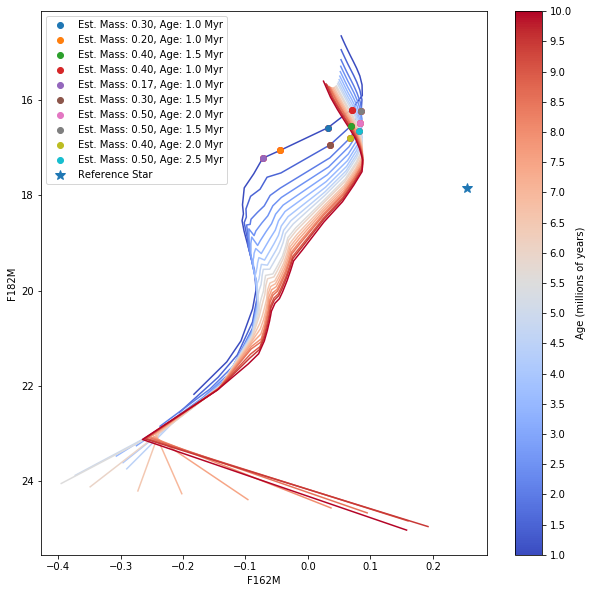

In [49]:
# Generate color-magnitude diagram
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('coolwarm')

# Plot all isochrones with colors based on age
for i, instance in enumerate(instances):
    color = cmap(i / (len(instances) - 1))  # Assign color based on index and colormap
    ax.plot(instance.points[filters[0]] - instance.points[filters[1]], instance.points[filters[1]], color=color)

ax.set_xlabel('F162M')
ax.set_ylabel('F182M')
ax.invert_yaxis()

# Create colorbar legend
norm = Normalize(vmin=min(level_ages), vmax=max(level_ages))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_ages)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_ages])

# Plot each estimated star's position in red on the diagram
for chi_square, mass, age in top_results:
    # Find the closest age in level_ages to the estimated age
    closest_age_idx = np.argmin(abs(level_ages - age))
    iso_instance = instances[closest_age_idx]  # Access the isochrone instance

    # Find the star in the isochrone closest to the estimated mass
    mass_idx = np.argmin(abs(iso_instance.points['mass'] - mass))
    
    # Plot the star's position on the color-magnitude diagram
    ax.plot(iso_instance.points[mass_idx][filters[0]] - iso_instance.points[mass_idx][filters[1]],
            iso_instance.points[mass_idx][filters[1]], 'o', color='red')

    # Plot each estimated star point with color gradient and labels
    ax.plot(
        iso_instance.points[mass_idx][filters[0]] - iso_instance.points[mass_idx][filters[1]],
        iso_instance.points[mass_idx][filters[1]],
        'o', label=f"Est. Mass: {mass:.2f}, Age: {age/1e6:.1f} Myr"
    )

# Plot reference star
ax.plot(sample_mags[star_index][0] - sample_mags[star_index][1], sample_mags[star_index][1], 
        '*', markersize=10, label="Reference Star")
    
ax.legend()
    
plt.show()

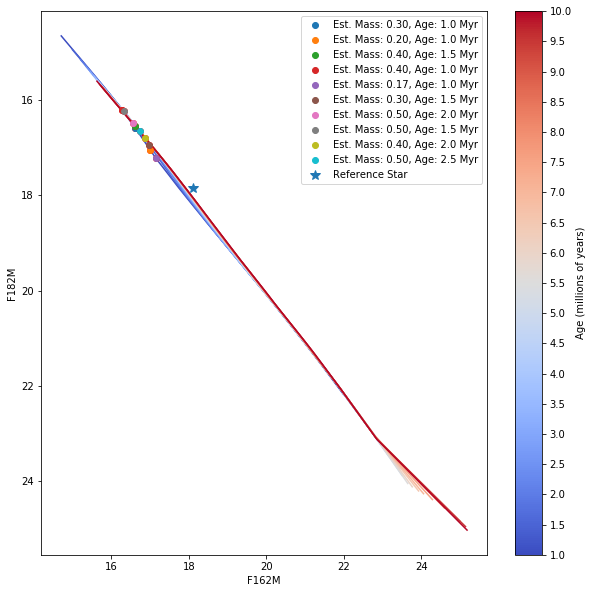

In [50]:
# Generate magnitude-magnitude diagram
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.get_cmap('coolwarm')

# Plot all isochrones with colors based on age
for i, instance in enumerate(instances):
    color = cmap(i / (len(instances) - 1))  # Assign color based on index and colormap
    ax.plot(instance.points[filters[0]], instance.points[filters[1]], color=color)

ax.set_xlabel('F162M')
ax.set_ylabel('F182M')
ax.invert_yaxis()

# Create colorbar legend
norm = Normalize(vmin=min(level_ages), vmax=max(level_ages))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_ages)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_ages])

# Plot each estimated star's position in red on the diagram
for chi_square, mass, age in top_results:
    # Find the closest age in level_ages to the estimated age
    closest_age_idx = np.argmin(abs(level_ages - age))
    iso_instance = instances[closest_age_idx]  # Access the isochrone instance

    # Find the star in the isochrone closest to the estimated mass
    mass_idx = np.argmin(abs(iso_instance.points['mass'] - mass))
    
    # Plot the star's position on the color-magnitude diagram
    ax.plot(iso_instance.points[mass_idx][filters[0]], iso_instance.points[mass_idx][filters[1]], 'o', color='red')

    # Plot each estimated star point with color gradient and labels
    ax.plot(
        iso_instance.points[mass_idx][filters[0]],
        iso_instance.points[mass_idx][filters[1]],
        'o', label=f"Est. Mass: {mass:.2f}, Age: {age/1e6:.1f} Myr"
    )

# Plot reference star
ax.plot(sample_mags[star_index][0], sample_mags[star_index][1], '*', 
        markersize=10, label="Reference Star")
    
ax.legend()
    
plt.show()